<a href="https://colab.research.google.com/github/YamenHabib/DeepLearning/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Petersburg in the eyes of Van Gogh

In [1]:
try:
    from google.colab import drive
    COLAB = True
    print("using Google CoLab")
except:
    print("not using Google CoLab")
    COLAB = False

using Google CoLab


importing our needed libs

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy

In [3]:
# define device. cuda if its avalable.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# we want the images in size 512 X 512
imsize = 512

In [5]:
# load trasform resizes the image then covert it to tensor.
load_transform  = transforms.Compose([transforms.Resize([imsize,imsize]),  transforms.ToTensor()]) 

In [6]:
# define a function to load image and apply our transfor on it.
def load_image(image_name):
    image = Image.open(image_name)
    image = load_transform (image).unsqueeze(0)
    return image.to(device, torch.float)

In [7]:
# convert tensor to PIL image
show_trasform = transforms.ToPILImage() 

In [8]:
# function to show our images.
def tensor2image(tensor):
    image = tensor.cpu().clone()
    # The input should have three dimensions
    image = image.squeeze(0)      
    image = show_trasform(image)
    return image

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# the path to our content and style image.
style_img = load_image("/content/drive/MyDrive/data/Neural Style Transfer/van_Gogh.jpg")
content_img = load_image("/content/drive/MyDrive/data/Neural Style Transfer/petersburg.jpg")

<Figure size 1080x1080 with 0 Axes>

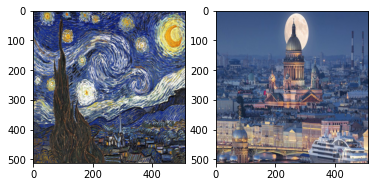

In [11]:
plt.figure(figsize=(15, 15))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(tensor2image(style_img))
ax2.imshow(tensor2image(content_img))

In [12]:
# the content loss is the mean square error between generated image and style image.
def content_loss(gen_features, orig_feautes):
  shared_keys = [k for k in gen_features if k in orig_feautes]
  loss_value = 0
  for k in shared_keys:
    gen = gen_features[k]
    orig = orig_feautes[k]
    loss_value += torch.mean((gen-orig)**2)
  # The factor wl was always equal to one divided by the number of active layers with a non-zero loss-weight wl.
  return loss_value / len(shared_keys)

In [13]:
def style_loss(gen_features, style_featues):
  shared_keys = [k for k in gen_features if k in orig_feautes]
  loss_value = 0
  for k in shared_keys:
    gen = gen_features[k]
    style = style_featues[k]
    
    N, C, H, W = gen.shape
    # calcualte the gram matrix of the generated image.
    r_g = gen.view(C, H * W)
    gen_gram=torch.mm(r_g,r_g.t())
    
    # calcualte the gram matrix of the style image.
    r_s = style.view(C, H * W)
    style_gram=torch.mm(r_s,r_s.t())
    # mean-squared distance between the entries of the Gram matrix from the original image and the Gram matrix of the image to be generated.
    loss_value += F.mse_loss(style_gram, gen_gram)
  # The factor wl was always equal to one divided by the number of active layers with a non-zero loss-weight wl.
  return loss_value/ len(shared_keys)

In [14]:
def loss(gen_features, orig_feautes, style_featues):
    style_loss_v = content_loss_v = 0    
    content_loss_v += content_loss(gen_features, orig_feautes)
    style_loss_v   += style_loss  (gen_features, style_featues)
    # the final loss is the weighted sum if the content and style losses.
    total_loss = alpha * content_loss_v + beta * style_loss_v
    return total_loss

In [15]:
class StyleTrasferModel(nn.Module):
    def __init__(self):
        super(StyleTrasferModel,self).__init__()
        self.model=models.vgg19(pretrained=True).features[:29] # we just need layers until 28 (conv5_1).
    
    def forward(self, x, needed_layers_activations):
        activations= {}
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in needed_layers_activations:
                activations[i] = x
        return activations

In [16]:
#Load the model to the GPU
model=StyleTrasferModel().to(device).eval() 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [17]:
epochs=2000
print_step = 500
lr=0.004
alpha= 1
beta=100

In [18]:
# copy the content image and put requires_grad_ true so we can backpropgate our losses.
generated_image = content_img.clone().requires_grad_(True)

#using adam optimizer on the generated image
optimizer=optim.Adam([generated_image], lr=lr)

style from  conv1_1,  conv2_1,  conv3_1,  conv4_1,  conv5_1

content from conv1_1,  conv2_1,  conv3_1,  conv4_1,  conv5_1

In [19]:
for e in range (epochs):
  # 0: conv1_1, 5: conv2_1, 10: conv3_1, 19: conv4_1, 28: conv5_1
  
  # for style we use: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
  gen_activations = style_activatons= [0,5,10,19,28]
  # for content we use: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
  orig_activations = [0,5,10,19,28]
  gen_features=model(generated_image, gen_activations)
  orig_feautes=model(content_img, orig_activations)
  style_featues=model(style_img, style_activatons)
  
  total_loss = loss(gen_features, orig_feautes, style_featues)
  # backpropogate
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  # save each print_step epoch
  if(not (e%print_step)):
    print(f"epoch: {e}/{epochs}: loss: {total_loss.data.cpu().numpy()}")
    save_image(generated_image, "gen.png")

epoch: 0/2000: loss: 6925364736.0
epoch: 500/2000: loss: 7495881.0
epoch: 1000/2000: loss: 3848710.25
epoch: 1500/2000: loss: 2751114.0


In [22]:
image_path = "/content/drive/MyDrive/data/Neural Style Transfer/all_layers.png"
save_image(generated_image, image_path)

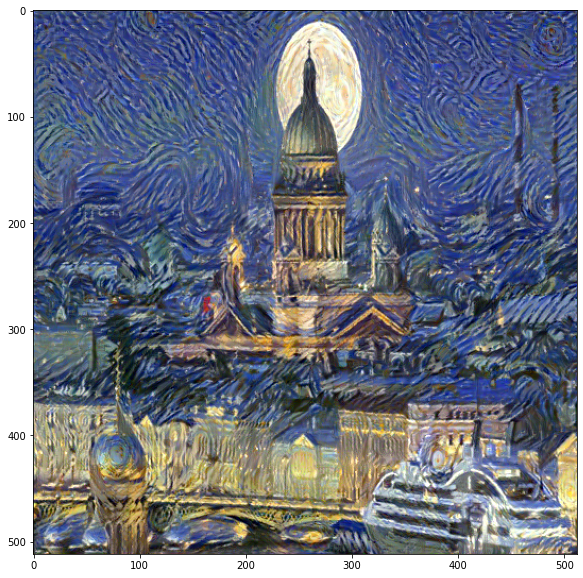

In [24]:
plt.figure(figsize=(10,10))
img = load_image(image_path)
plt.imshow(tensor2image(img))

style from  conv1_1,  conv2_1,  conv3_1,  conv4_1,  conv5_1

content from conv5_1

In [25]:
# copy the content image and put requires_grad_ true so we can backpropgate our losses.
generated_image = content_img.clone().requires_grad_(True)

#using adam optimizer on the generated image
optimizer=optim.Adam([generated_image], lr=lr)

In [26]:
for e in range (epochs):
  # 0: conv1_1, 5: conv2_1, 10: conv3_1, 19: conv4_1, 28: conv5_1
  
  # for style we use: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
  gen_activations = style_activatons= [0,5,10,19,28]
  # for content we use: conv5_1
  orig_activations = [28]
  gen_features=model(generated_image, gen_activations)
  orig_feautes=model(content_img, orig_activations)
  style_featues=model(style_img, style_activatons)
  
  total_loss = loss(gen_features, orig_feautes, style_featues)
  # backpropogate
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  # save each print_step epoch
  if(not (e%print_step)):
    print(f"epoch: {e}/{epochs}: loss: {total_loss.data.cpu().numpy()}")
    save_image(generated_image, "gen.png")

epoch: 0/2000: loss: 3713415168.0
epoch: 500/2000: loss: 2829801.0
epoch: 1000/2000: loss: 1920962.625
epoch: 1500/2000: loss: 1492786.25


In [27]:
image_path = "/content/drive/MyDrive/data/Neural Style Transfer/conv5_1.png"
save_image(generated_image, image_path)

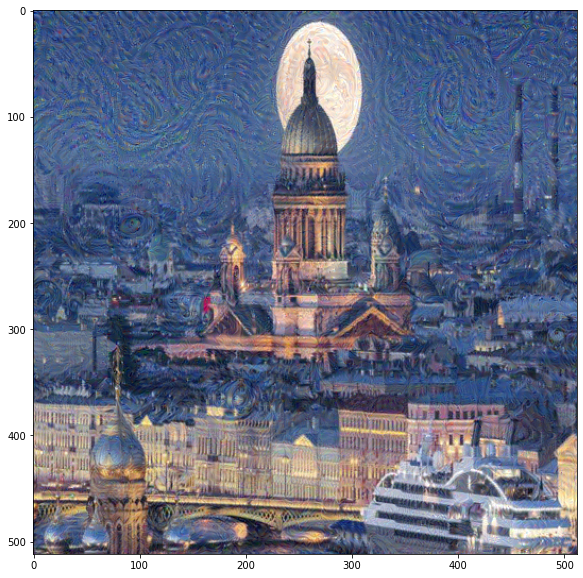

In [28]:
plt.figure(figsize=(10,10))
img = load_image(image_path)
plt.imshow(tensor2image(img))

style from  conv1_1,  conv2_1,  conv3_1,  conv4_1,  conv5_1

content from conv2_1

In [29]:
# copy the content image and put requires_grad_ true so we can backpropgate our losses.
generated_image = content_img.clone().requires_grad_(True)

#using adam optimizer on the generated image
optimizer=optim.Adam([generated_image], lr=lr)

In [30]:
for e in range (epochs):
  # 0: conv1_1, 5: conv2_1, 10: conv3_1, 19: conv4_1, 28: conv5_1
  
  # for style we use: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
  gen_activations = style_activatons= [0,5,10,19,28]
  # for content we use: conv2_1
  orig_activations = [5]
  gen_features=model(generated_image, gen_activations)
  orig_feautes=model(content_img, orig_activations)
  style_featues=model(style_img, style_activatons)
  
  total_loss = loss(gen_features, orig_feautes, style_featues)
  # backpropogate
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  # save each print_step epoch
  if(not (e%print_step)):
    print(f"epoch: {e}/{epochs}: loss: {total_loss.data.cpu().numpy()}")
    save_image(generated_image, "gen.png")

epoch: 0/2000: loss: 13483513856.0
epoch: 500/2000: loss: 2115435.5
epoch: 1000/2000: loss: 479832.59375
epoch: 1500/2000: loss: 166463.359375


In [31]:
image_path = "/content/drive/MyDrive/data/Neural Style Transfer/conv2_1.png"
save_image(generated_image, image_path)

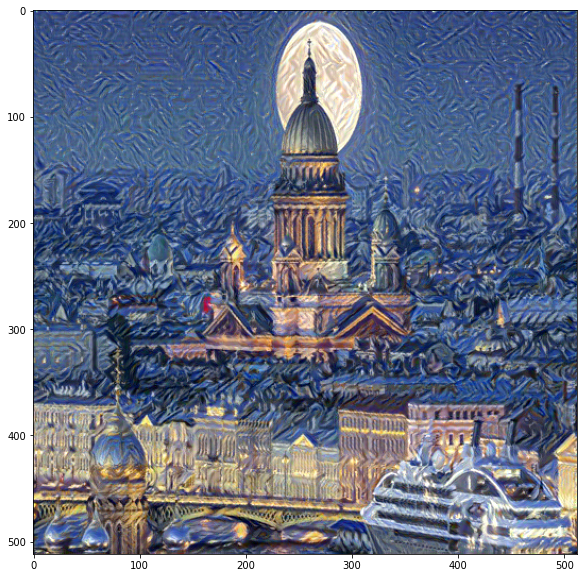

In [32]:
plt.figure(figsize=(10,10))
img = load_image(image_path)
plt.imshow(tensor2image(img))